In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_1samp, poisson
%matplotlib inline

# Simple statistics and quantifying uncertainty

In any data analysis, it's important to visualize distributions and quantify statistics about those distributions. In this tutorial we'll cover a few ways of doing this.

First, we'll generate two random datasets. They'll both be normal distributions with the following parameters.

In [2]:
# The data
# N = 25
N = 75
mu1 = 7
mu2 = 10
sd = 5

In [3]:
# Generate random data
data1 = sd * np.random.randn(N) + mu1
data2 = sd * np.random.randn(N) + mu2

As a first step let's plot the histograms of each dataset. This is a good high-level idea for whether these two distributions differ. 

(array([  3.,   9.,  12.,  19.,  18.,   9.,   3.,   1.,   0.,   1.]),
 array([ -0.24247525,   2.71075457,   5.6639844 ,   8.61721422,
         11.57044405,  14.52367387,  17.4769037 ,  20.43013353,
         23.38336335,  26.33659318,  29.289823  ]),
 <a list of 10 Patch objects>)

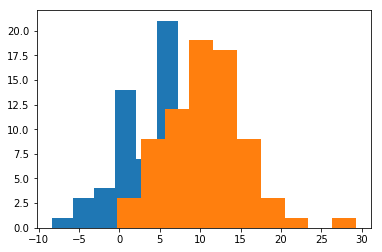

In [4]:
# Histograms
fig, ax = plt.subplots()
ax.hist(data1)
ax.hist(data2)

We'll run an old-fashioned t-test to find a p-value for whether these distributions are different. This test calculates the difference in mean of each distribution, and weights this by their standard deviations.

In [5]:
result = ttest_ind(data1, data2)
print(result.pvalue)

4.0311874612e-10


Rather than visualizing the raw histograms, it's common to look at a bar plot of the data, along with some metric of "variability" of each group of data. If you could only look at this bar plot (in a paper figure, for instance), would you be able to tell if the difference was significant? 

Now we'll repeat for standard error. Compare and contrast the information provided by each metric. As you might notice, the standard error is much smaller. Try making the same plot, but using a larger `N`. The standard error will change. This is because standard error is meant to represent the error in the *mean* of the distribution, whereas standard deviation describes the distribution itself.

In [6]:
# Means and standard deviations of each dataset
mn1 = np.mean(data1)
mn2 = np.mean(data2)

std1 = np.std(data1)
std2 = np.std(data2)

# Now standard error
ste1 = std1 / np.sqrt(N)
ste2 = std2 / np.sqrt(N)

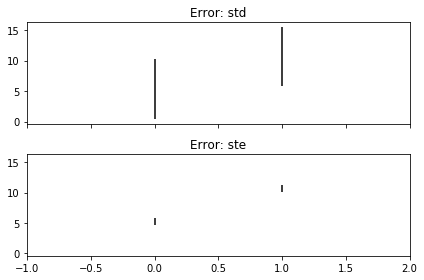

In [7]:
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
for ax, err1, err2, nm in zip(axs, [std1, ste1], [std2, ste2], ['std', 'ste']):
    ax.vlines([0, 1], [mn1 - err1, mn2 - err2], [mn1 + err1, mn2 + err2])
    _ = plt.setp(ax, xlim=[-1, 2], title='Error: {}'.format(nm))
plt.tight_layout()

# Merging the two
Even better than a barplot, we can simultaneously show the histrograms as well as their standard errors:

(0.0, 27.252500000000001)

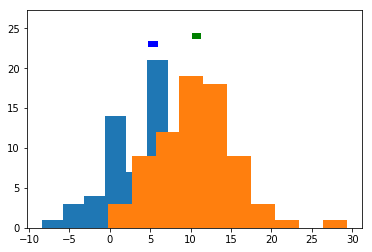

In [8]:
fig, ax = plt.subplots()
ax.hist(data1)
ax.hist(data2)

ymax = ax.get_ylim()[-1]
for ii, (imn, iste, c) in enumerate([(mn1, ste1, 'b'), (mn2, ste2, 'g')]):
    ax.hlines(ymax + 1 + ii, imn - iste, imn + iste, lw=6, color=c)
ax.set_ylim([None, ax.get_ylim()[-1] + 2])

# Calculating uncertainty with computation: the bootstrap
The standard error that we've shown above in some sense depends on assumptions we're making on the data. By calculating standard error, we're assuming a couple of things at least:

1. The mean is a good description of the distribution
2. The error is roughly symmetric about the mean

But what if our distribution looked something like this:

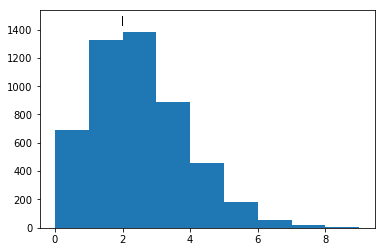

In [9]:
data = np.random.poisson(lam=2, size=5000)

mn = data.mean()
ste = data.std() / np.sqrt(data.shape[0])

fig, ax = plt.subplots()
ax.hist(data, bins=np.arange(0, 10, 1))
ax.hlines(ax.get_ylim()[-1] + 10, mn - ste, mn + ste, lw=10)

As you can see above, this is *not* a symmetric distribution, so we can' just calculate its mean / standard error and call it a day.

Luckily, with modern computational power we can *simulate* the uncertainty in the mean of this distribution. One way of doing this is called the *bootstrap*.

Briefly, the bootstrap follows these steps:

1. Take a random sample of our data points, of the same size as our dataset. Take this random sample *with replacement*
2. Calculate the mean (or whatever statistic) of the sample.
3. Collect this mean and repeat this N times (maybe 1000).
4. Calculate percentiles of the distribution of our simulated means as a proxy for uncertainty of the statistic.

Here's what it looks like in practice:

In [10]:
n_boots = 1000
means = np.zeros(n_boots)
for ii in range(n_boots):
    ixs_sample = np.random.randint(0, data.shape[0], size=data.shape[0])
    sample = data[ixs_sample]
    means[ii] = sample.mean()

Now we can plot the distribution of our means, as well as the 2.5th and 97.5th percentiles of this distribution (corresponding to a 95% confidence interval)

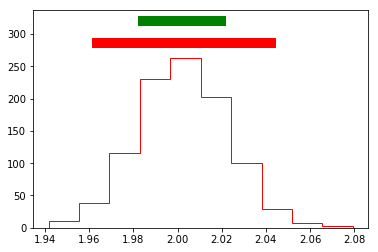

In [11]:
# Calculate confidence intervals
clo, chi = np.percentile(means, [2.5, 97.5])

fig, ax = plt.subplots()

ax.hist(means, histtype='step', color='r')
ax.hlines(ax.get_ylim()[-1] + 10, clo, chi, lw=10, color='r')
ax.hlines(ax.get_ylim()[-1] + 20, mn - ste, mn + ste, lw=10, color='g')

Note the difference between the green and red horizontal bars. The green bar is thinner, representing an overconfidence in the "true" mean of the distribution. Because the distribution is not symmetric, this is wrong, and a better description of the distribution is given by the bootstrapped confidence interval.